In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
from tqdm import tqdm
import tensorflow as tf
import time 
import warnings
warnings.filterwarnings("ignore")
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import math
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
FOLDERNAME = 'energy'
assert FOLDERNAME is not None, "[!] Enter the foldername."
import plotly.express as px
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/energy


In [2]:
train = pd.read_csv('train.csv', header=0, encoding='euc-kr') 
test = pd.read_csv('test.csv',  header=0, encoding='euc-kr')
sample_submission = pd.read_csv('sample_submission.csv', header=0, encoding='euc-kr') 

In [3]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   num         122400 non-null  int64  
 1   date_time   122400 non-null  object 
 2   전력사용량(kWh)  122400 non-null  float64
 3   기온(°C)      122400 non-null  float64
 4   풍속(m/s)     122400 non-null  float64
 5   습도(%)       122400 non-null  float64
 6   강수량(mm)     122400 non-null  float64
 7   일조(hr)      122400 non-null  float64
 8   비전기냉방설비운영   122400 non-null  float64
 9   태양광보유       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


In [5]:
test.head(10)

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,2020-08-25 05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,2020-08-25 06,26.1,1.3,83.0,0.0,0.0,NaN,NaN
7,1,2020-08-25 07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,2020-08-25 08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,2020-08-25 09,28.8,1.2,77.0,NaN,1.1,NaN,NaN


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num           10080 non-null  int64  
 1   date_time     10080 non-null  object 
 2   기온(°C)        3360 non-null   float64
 3   풍속(m/s)       3360 non-null   float64
 4   습도(%)         3360 non-null   float64
 5   강수량(mm, 6시간)  1680 non-null   float64
 6   일조(hr, 3시간)   3360 non-null   float64
 7   비전기냉방설비운영     2296 non-null   float64
 8   태양광보유         1624 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 708.9+ KB


In [7]:
train.describe()

,num,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
count,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000
mean,30.500000,2324.830866,24.251713,2.151641,80.169848,0.514989,0.213533,0.683333,0.483333
std,17.318173,2058.999326,3.407902,1.514475,15.525862,2.624505,0.370517,0.465178,0.499724
min,1.000000,0.000000,11.100000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000
25%,15.750000,1055.268000,21.800000,1.100000,70.000000,0.000000,0.000000,0.000000,0.000000
50%,30.500000,1700.352000,24.200000,1.900000,84.000000,0.000000,0.000000,1.000000,0.000000
75%,45.250000,2780.487000,26.500000,2.900000,93.000000,0.000000,0.300000,1.000000,1.000000
max,60.000000,17739.225000,36.300000,20.100000,100.000000,81.500000,1.000000,1.000000,1.000000


In [8]:
test.describe()

,num,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
count,10080.000000,3360.000000,3360.000000,3360.000000,1680.000000,3360.000000,2296.0,1624.0
mean,30.500000,27.805804,2.440327,81.963095,2.191845,0.612917,1.0,1.0
std,17.318961,2.378122,1.835905,11.900843,6.786772,0.929587,0.0,0.0
min,1.000000,22.100000,0.000000,44.000000,0.000000,0.000000,1.0,1.0
25%,15.750000,26.000000,1.100000,74.000000,0.000000,0.000000,1.0,1.0
50%,30.500000,27.500000,2.100000,83.000000,0.000000,0.000000,1.0,1.0
75%,45.250000,29.200000,3.200000,92.000000,0.900000,1.000000,1.0,1.0
max,60.000000,35.400000,22.500000,100.000000,83.500000,3.000000,1.0,1.0


In [9]:
test.isnull().sum()

num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
dtype: int64

In [10]:
#train의 건물번호를 이용하여 test의 결측치를 채움
building_info = train[['num','비전기냉방설비운영', '태양광보유']].drop_duplicates()
test.drop(columns=['비전기냉방설비운영', '태양광보유'], inplace = True)
test = pd.merge(test, building_info, on= 'num')


In [11]:
train['date'] = train['date_time'].apply(lambda x: x.split()[0])
train['date_time'] = train['date_time'].apply(lambda x: x.split()[1])
test['date'] = test['date_time'].apply(lambda x: x.split()[0])
test['date_time'] = test['date_time'].apply(lambda x: x.split()[1])

In [12]:
train_ = train.copy()

In [13]:
def make_train_nan(col, n):
    new_list = []
    for idx, temp in enumerate(train_[col]):
        if idx%n==0:
            new_list.append(temp)
        else:
            new_list.append(np.nan)
    train_['{}'.format(col+'_nan')] = new_list

In [14]:
make_train_nan('기온(°C)',3)
make_train_nan('풍속(m/s)',3)
make_train_nan('습도(%)',3)
make_train_nan('일조(hr)',3)
#기온(°C),풍속(m/s), 습도(%), 일조(hr, 3시간): 3시간 단위로만 값이 있음
make_train_nan('강수량(mm)',6)
#강수량(mm): 6시간 단위



In [15]:
def compare_interpolate_methods(col, methods, metric):
    error_dict = dict()
    for method in methods:
        fillna = train_['{}'.format(col+'_nan')].interpolate(method=method)
        if fillna.isna().sum() != 0:
            fillna = fillna.interpolate(method='linear')
        error = metric(train_['{}'.format(col)], fillna)
        error_dict['{}'.format(method)] = error
    
    return error_dict

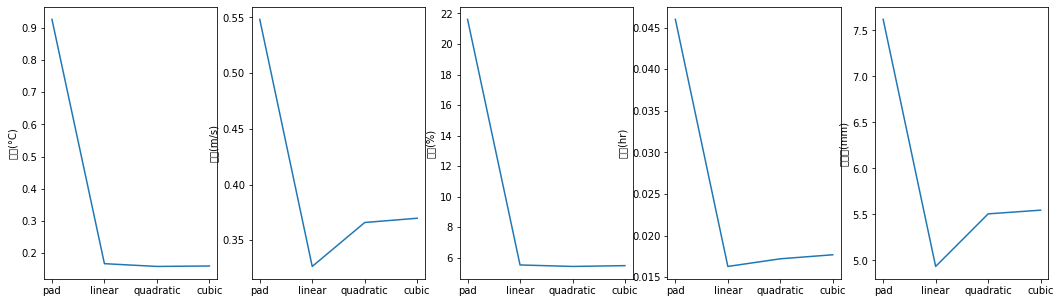

In [16]:
from sklearn.metrics import mean_squared_error
all_cols_error_dict = dict()
for col in ['기온(°C)', '풍속(m/s)', '습도(%)', '일조(hr)','강수량(mm)']:
    methods = ['pad','linear','quadratic','cubic']
    error_dict = compare_interpolate_methods(col, methods, mean_squared_error)
    all_cols_error_dict['{}'.format(col)] = error_dict
    
all_cols_error_df = pd.DataFrame(all_cols_error_dict)

fig, axes = plt.subplots(1,5, figsize = (18,5), sharey=False)
for i in range(len(all_cols_error_df.columns)):
    sns.lineplot(ax=axes[i], data=all_cols_error_df.iloc[:,i].transpose())

In [17]:
test['기온(°C)'] = test['기온(°C)'].interpolate(method='quadratic')
#마지막 na 채우기
test['기온(°C)'] = test['기온(°C)'].interpolate(method='linear')

#풍속 결측치 채우기
test['풍속(m/s)'] = test['풍속(m/s)'].interpolate(method='linear')

#습도 결측치 채우기
test['습도(%)'] = test['습도(%)'].interpolate(method='quadratic')
#마지막 na 채우기
test['습도(%)'] = test['습도(%)'].interpolate(method='linear')
test['일조(hr, 3시간)'] = test['일조(hr, 3시간)'].interpolate(method='linear')
#강수량 결측치 채우기
test['강수량(mm, 6시간)'] = test['강수량(mm, 6시간)'].interpolate(method='linear')

In [18]:
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,date
0,1,00,27.800000,1.500000,74.000000,0.0,0.0,0.0,0.0,2020-08-25
1,1,01,27.806027,1.366667,75.017358,0.0,0.0,0.0,0.0,2020-08-25
2,1,02,27.639360,1.233333,76.350691,0.0,0.0,0.0,0.0,2020-08-25
3,1,03,27.300000,1.100000,78.000000,0.0,0.0,0.0,0.0,2020-08-25
4,1,04,26.787947,1.166667,79.965285,0.0,0.0,0.0,0.0,2020-08-25


In [19]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,date
0,1,00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020-06-01
1,1,01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020-06-01
2,1,02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01
3,1,03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01
4,1,04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020-06-01


In [20]:
train['date_time'] = train['date'] + ' ' + train['date_time']
test['date_time'] = test['date'] + ' ' + test['date_time']


In [21]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,date
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020-06-01
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020-06-01
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020-06-01


In [22]:
train['date_time'] = pd.to_datetime(train['date_time'])
test['date_time'] = pd.to_datetime(test['date_time'])


In [23]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,date
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020-06-01
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020-06-01
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020-06-01


In [24]:
sample_submission

,num_date_time,answer
0,1 2020-08-25 00,0
1,1 2020-08-25 01,0
2,1 2020-08-25 02,0
3,1 2020-08-25 03,0
4,1 2020-08-25 04,0
...,...,...
10075,60 2020-08-31 19,0
10076,60 2020-08-31 20,0
10077,60 2020-08-31 21,0
10078,60 2020-08-31 22,0


In [25]:
train['month'] = train['date_time'].dt.month
train['hour'] = train['date_time'].dt.hour
test['month'] = test['date_time'].dt.month
test['hour'] = test['date_time'].dt.hour

In [26]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,date,month,hour
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020-06-01,6,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020-06-01,6,1
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,6,2
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,6,3
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020-06-01,6,4


In [27]:
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,date,month,hour
0,1,2020-08-25 00:00:00,27.800000,1.500000,74.000000,0.0,0.0,0.0,0.0,2020-08-25,8,0
1,1,2020-08-25 01:00:00,27.806027,1.366667,75.017358,0.0,0.0,0.0,0.0,2020-08-25,8,1
2,1,2020-08-25 02:00:00,27.639360,1.233333,76.350691,0.0,0.0,0.0,0.0,2020-08-25,8,2
3,1,2020-08-25 03:00:00,27.300000,1.100000,78.000000,0.0,0.0,0.0,0.0,2020-08-25,8,3
4,1,2020-08-25 04:00:00,26.787947,1.166667,79.965285,0.0,0.0,0.0,0.0,2020-08-25,8,4


<BarContainer object of 3 artists>

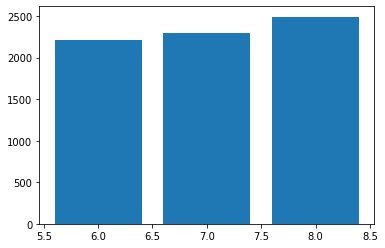

In [28]:
mean_month = train.groupby('month').mean()
plt.bar(mean_month.index,mean_month['전력사용량(kWh)'])

<BarContainer object of 3 artists>

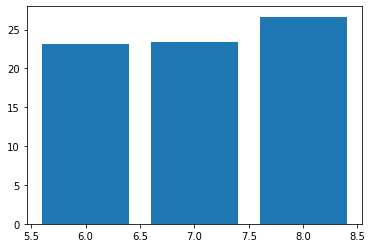

In [29]:
plt.bar(mean_month.index,mean_month['기온(°C)'])

<BarContainer object of 3 artists>

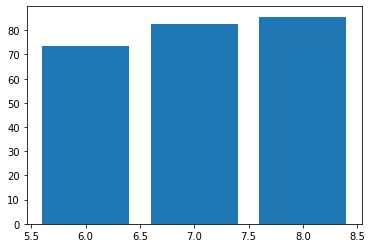

In [30]:
plt.bar(mean_month.index,mean_month['습도(%)'])

<BarContainer object of 3 artists>

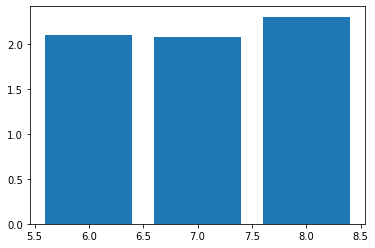

In [31]:
plt.bar(mean_month.index,mean_month['풍속(m/s)'])

<BarContainer object of 3 artists>

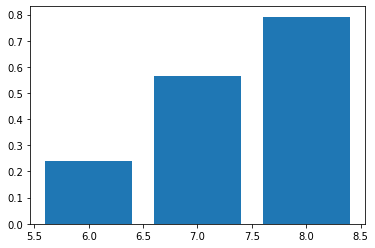

In [32]:
plt.bar(mean_month.index,mean_month['강수량(mm)'])

<BarContainer object of 3 artists>

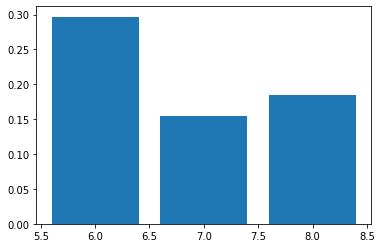

In [33]:
plt.bar(mean_month.index,mean_month['일조(hr)'])

<BarContainer object of 24 artists>

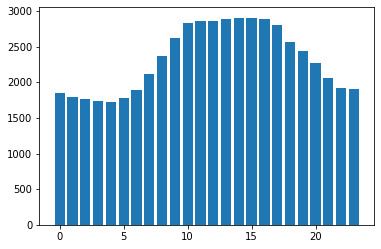

In [34]:
mean_hour = train.groupby('hour').mean()
plt.bar(mean_hour.index,mean_hour['전력사용량(kWh)'])

      num           date_time  전력사용량(kWh)  ...        date  month  hour
0       1 2020-06-01 00:00:00    8179.056  ...  2020-06-01      6     0
1       1 2020-06-01 01:00:00    8135.640  ...  2020-06-01      6     1
2       1 2020-06-01 02:00:00    8107.128  ...  2020-06-01      6     2
3       1 2020-06-01 03:00:00    8048.808  ...  2020-06-01      6     3
4       1 2020-06-01 04:00:00    8043.624  ...  2020-06-01      6     4
...   ...                 ...         ...  ...         ...    ...   ...
2035    1 2020-08-24 19:00:00    8714.952  ...  2020-08-24      8    19
2036    1 2020-08-24 20:00:00    8740.224  ...  2020-08-24      8    20
2037    1 2020-08-24 21:00:00    8730.504  ...  2020-08-24      8    21
2038    1 2020-08-24 22:00:00    8725.968  ...  2020-08-24      8    22
2039    1 2020-08-24 23:00:00    8705.232  ...  2020-08-24      8    23

[2040 rows x 13 columns]


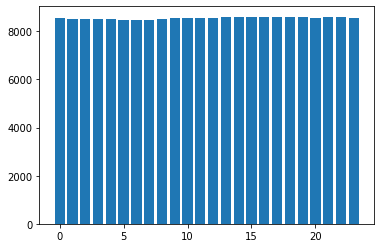

      num           date_time  전력사용량(kWh)  ...        date  month  hour
2040    2 2020-06-01 00:00:00     977.184  ...  2020-06-01      6     0
2041    2 2020-06-01 01:00:00     966.168  ...  2020-06-01      6     1
2042    2 2020-06-01 02:00:00     972.972  ...  2020-06-01      6     2
2043    2 2020-06-01 03:00:00     965.844  ...  2020-06-01      6     3
2044    2 2020-06-01 04:00:00     971.676  ...  2020-06-01      6     4
...   ...                 ...         ...  ...         ...    ...   ...
4075    2 2020-08-24 19:00:00    1353.348  ...  2020-08-24      8    19
4076    2 2020-08-24 20:00:00    1260.036  ...  2020-08-24      8    20
4077    2 2020-08-24 21:00:00    1214.028  ...  2020-08-24      8    21
4078    2 2020-08-24 22:00:00    1126.224  ...  2020-08-24      8    22
4079    2 2020-08-24 23:00:00    1107.432  ...  2020-08-24      8    23

[2040 rows x 13 columns]


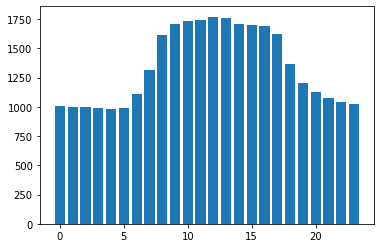

      num           date_time   전력사용량(kWh)  ...        date  month  hour
4080    3 2020-06-01 00:00:00  3183.624000  ...  2020-06-01      6     0
4081    3 2020-06-01 01:00:00  3171.636000  ...  2020-06-01      6     1
4082    3 2020-06-01 02:00:00  3175.740000  ...  2020-06-01      6     2
4083    3 2020-06-01 03:00:00  3194.856000  ...  2020-06-01      6     3
4084    3 2020-06-01 04:00:00  3198.528000  ...  2020-06-01      6     4
...   ...                 ...          ...  ...         ...    ...   ...
6115    3 2020-08-24 19:00:00  3572.334982  ...  2020-08-24      8    19
6116    3 2020-08-24 20:00:00  3571.432457  ...  2020-08-24      8    20
6117    3 2020-08-24 21:00:00  3569.301794  ...  2020-08-24      8    21
6118    3 2020-08-24 22:00:00  3549.660490  ...  2020-08-24      8    22
6119    3 2020-08-24 23:00:00  3465.782444  ...  2020-08-24      8    23

[2040 rows x 13 columns]


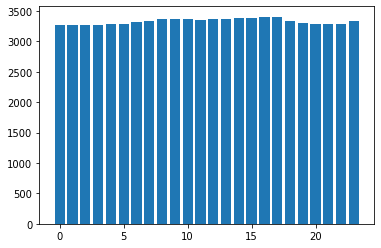

      num           date_time  전력사용량(kWh)  ...        date  month  hour
6120    4 2020-06-01 00:00:00     339.552  ...  2020-06-01      6     0
6121    4 2020-06-01 01:00:00     387.504  ...  2020-06-01      6     1
6122    4 2020-06-01 02:00:00     203.472  ...  2020-06-01      6     2
6123    4 2020-06-01 03:00:00     186.192  ...  2020-06-01      6     3
6124    4 2020-06-01 04:00:00     185.760  ...  2020-06-01      6     4
...   ...                 ...         ...  ...         ...    ...   ...
8155    4 2020-08-24 19:00:00     729.648  ...  2020-08-24      8    19
8156    4 2020-08-24 20:00:00     700.272  ...  2020-08-24      8    20
8157    4 2020-08-24 21:00:00     569.376  ...  2020-08-24      8    21
8158    4 2020-08-24 22:00:00     375.408  ...  2020-08-24      8    22
8159    4 2020-08-24 23:00:00     340.416  ...  2020-08-24      8    23

[2040 rows x 13 columns]


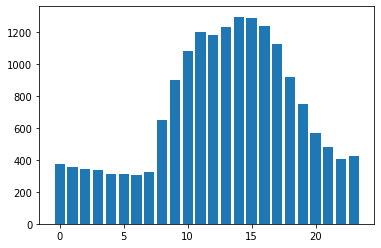

       num           date_time  전력사용량(kWh)  ...        date  month  hour
8160     5 2020-06-01 00:00:00    3063.744  ...  2020-06-01      6     0
8161     5 2020-06-01 01:00:00    3147.120  ...  2020-06-01      6     1
8162     5 2020-06-01 02:00:00    3098.736  ...  2020-06-01      6     2
8163     5 2020-06-01 03:00:00    3047.760  ...  2020-06-01      6     3
8164     5 2020-06-01 04:00:00    3111.696  ...  2020-06-01      6     4
...    ...                 ...         ...  ...         ...    ...   ...
10195    5 2020-08-24 19:00:00    3439.152  ...  2020-08-24      8    19
10196    5 2020-08-24 20:00:00    3510.432  ...  2020-08-24      8    20
10197    5 2020-08-24 21:00:00    3458.160  ...  2020-08-24      8    21
10198    5 2020-08-24 22:00:00    3421.008  ...  2020-08-24      8    22
10199    5 2020-08-24 23:00:00    3355.344  ...  2020-08-24      8    23

[2040 rows x 13 columns]


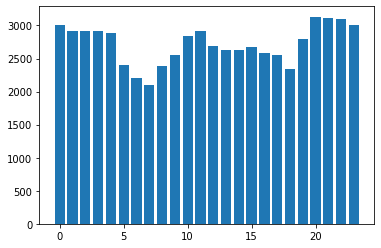

In [35]:

for i in range(5):
  p = train[train['num'] == i+1]
  print(p)
  p = p.groupby('hour').median()
  plt.bar(p.index,p['전력사용량(kWh)'])
  plt.show()

In [36]:
train_origin = train.copy()

# 군집화를 통한 유형 분류
건물 번호와 시간대별, 일별(주말,공휴일) 전력사용량으로 데이터를 군집화


In [37]:
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,date,month,hour
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020-06-01,6,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020-06-01,6,1
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,6,2
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,6,3
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020-06-01,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,2020-08-24,8,19
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,2020-08-24,8,20
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,2020-08-24,8,21
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,2020-08-24,8,22


In [38]:
for i in range(1, 61):
    mean_ = train.loc[train.num == i]['전력사용량(kWh)'].mean()
    std_ = train.loc[train.num == i]['전력사용량(kWh)'].std()
    train.loc[train.num == i, '전력사용량(kWh)'] = ((train.loc[train.num == i, '전력사용량(kWh)']) - mean_) / std_

In [39]:
train['weekday'] = train.date_time.dt.weekday
test['weekday'] = test.date_time.dt.weekday
train.loc[train.weekday >= 5, 'holiday'] = 1
train.loc[train.weekday < 5, 'holiday'] = 0
train.loc[(train.month == 8) & (train.date_time.dt.day == 17), 'holiday'] = 1

test.loc[test.weekday >= 5, 'holiday'] = 1
test.loc[test.weekday < 5, 'holiday'] = 0


In [40]:
weekday_mean = (
    train.groupby(['num', 'weekday'])['전력사용량(kWh)'].mean()
    .reset_index()
    .pivot('num', 'weekday', '전력사용량(kWh)')
    .reset_index()
)

In [41]:
hour_mean = (
    train.groupby(['num', 'hour'])['전력사용량(kWh)'].mean()
    .reset_index()
    .pivot('num', 'hour', '전력사용량(kWh)')
    .reset_index()
    .drop('num', axis=1)
)

In [42]:
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,date,month,hour,weekday,holiday
0,1,2020-06-01 00:00:00,-2.795969,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020-06-01,6,0,0,0.0
1,1,2020-06-01 01:00:00,-3.129259,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020-06-01,6,1,0,0.0
2,1,2020-06-01 02:00:00,-3.348135,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,6,2,0,0.0
3,1,2020-06-01 03:00:00,-3.795838,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,6,3,0,0.0
4,1,2020-06-01 04:00:00,-3.835633,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020-06-01,6,4,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,1.840746,27.8,2.3,68.0,0.0,0.7,1.0,1.0,2020-08-24,8,19,0,0.0
122396,60,2020-08-24 20:00:00,1.504699,27.3,1.2,71.0,0.0,0.0,1.0,1.0,2020-08-24,8,20,0,0.0
122397,60,2020-08-24 21:00:00,0.526918,27.3,1.8,71.0,0.0,0.0,1.0,1.0,2020-08-24,8,21,0,0.0
122398,60,2020-08-24 22:00:00,-0.134708,27.1,1.8,74.0,0.0,0.0,1.0,1.0,2020-08-24,8,22,0,0.0


In [43]:
columns = (
    ['num']
    + ['day_mean_' + str(i) for i in range(7)]
    + ['hour_mean_' + str(i) for i in range(24)]
)

In [44]:
cl_df = pd.concat([weekday_mean, hour_mean], axis=1)

In [45]:
cl_df.columns = columns

In [46]:
cl_df

,num,day_mean_0,day_mean_1,day_mean_2,day_mean_3,day_mean_4,day_mean_5,day_mean_6,hour_mean_0,hour_mean_1,hour_mean_2,hour_mean_3,hour_mean_4,hour_mean_5,hour_mean_6,hour_mean_7,hour_mean_8,hour_mean_9,hour_mean_10,hour_mean_11,hour_mean_12,hour_mean_13,hour_mean_14,hour_mean_15,hour_mean_16,hour_mean_17,hour_mean_18,hour_mean_19,hour_mean_20,hour_mean_21,hour_mean_22,hour_mean_23
0,1,-0.013265,-0.275141,0.065127,0.136859,0.207538,0.004373,-0.124387,-0.022265,-0.200351,-0.262678,-0.383528,-0.489396,-0.679831,-0.742802,-0.521233,-0.421568,-0.098813,0.080561,0.148447,0.154768,0.259817,0.438781,0.486945,0.490691,0.413908,0.283379,0.294580,0.227571,0.228683,0.234710,0.079624
1,2,0.219825,0.246954,0.266059,0.304359,0.269986,-0.613713,-0.711788,-0.843264,-0.871100,-0.879888,-0.898835,-0.905131,-0.885721,-0.588434,-0.023260,0.693620,0.929527,0.923558,0.938620,0.980533,0.993942,0.927692,0.887512,0.828227,0.656724,0.131663,-0.303718,-0.510565,-0.631740,-0.747649,-0.802314
2,3,-0.001191,0.002234,0.155745,0.198316,0.176369,-0.176871,-0.354502,0.068953,0.104412,0.076977,0.155155,0.166295,0.154152,0.269729,0.393576,0.428908,0.068273,0.004004,-0.364266,-0.451589,-0.296118,-0.179592,0.098628,0.158603,0.145217,-0.076369,-0.251865,-0.282285,-0.342865,-0.345398,0.297465
3,4,-0.156680,-0.169906,-0.071670,0.060515,0.121706,0.223918,0.005172,-0.738844,-0.803466,-0.838857,-0.869723,-0.901720,-0.915776,-0.912289,-0.883360,-0.188128,0.419805,0.918855,1.030169,1.016926,1.062611,1.145659,1.201668,1.142114,0.907742,0.348254,0.022042,-0.321251,-0.510391,-0.682189,-0.649852
4,5,0.014861,-0.025999,-0.040268,-0.070623,0.304741,0.074887,-0.258837,0.581476,0.466763,0.427613,0.399576,0.372876,-0.726423,-1.259373,-1.440235,-0.757198,-0.334699,0.273951,0.441576,-0.059186,-0.162474,-0.168711,-0.120386,-0.313461,-0.438549,-0.915961,0.234951,0.996338,0.953813,0.837413,0.710313
5,6,0.239624,0.275555,0.289593,0.320184,0.242848,-0.656089,-0.731683,-0.758322,-0.787952,-0.802875,-0.811953,-0.819763,-0.818470,-0.762856,-0.551859,0.005864,0.719264,0.941192,0.971193,0.909571,1.052032,1.068799,1.093774,0.988323,0.758786,0.152144,-0.200608,-0.398406,-0.559937,-0.664397,-0.723545
6,7,0.308081,0.351413,0.355795,0.376162,0.328339,-0.837755,-0.907708,-0.157294,-0.232214,-0.348710,-0.940138,-1.139106,-0.733455,-0.086328,0.268705,0.588561,0.727206,0.755061,0.724931,0.724568,0.782457,0.754134,0.753592,0.616245,0.472445,-0.047339,-0.437074,-0.699004,-0.960075,-1.209311,-0.177855
7,8,0.240374,0.312103,0.312793,0.333075,0.277319,-0.761506,-0.734188,-0.768750,-0.785878,-0.786958,-0.812258,-0.812800,-0.800925,-0.677336,-0.131069,0.511979,0.830958,0.880575,0.889071,0.793749,0.926784,0.931289,0.904027,0.919012,0.673893,-0.074734,-0.317675,-0.440836,-0.536507,-0.628548,-0.687064
8,9,-0.076799,-0.024610,0.062988,-0.028592,0.146792,0.137982,-0.211361,0.543305,0.464203,0.384287,0.279442,0.174635,0.003389,-0.264108,-0.376922,-0.473931,-0.628690,-0.732929,-0.789741,-0.803141,-0.691703,-0.532002,-0.338251,-0.008248,0.248185,0.447492,0.642824,0.628659,0.655559,0.610731,0.556955
9,10,-0.142424,0.015979,0.005308,0.008066,0.065480,0.038569,0.020890,-0.956902,-0.962494,-0.970966,-0.982711,-0.987087,-0.997894,-0.968067,-0.913912,-0.683744,0.520235,1.191576,1.193495,1.194278,1.177486,1.157899,1.118520,1.097510,1.086865,1.036986,0.539623,-0.330522,-0.763423,-0.867798,-0.928955


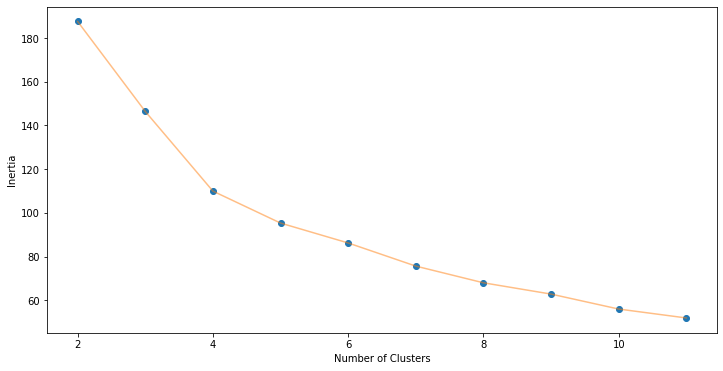

In [47]:
from sklearn.cluster import KMeans
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (12, 6))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], cl_df.iloc[:,1:])

In [48]:
model = KMeans(n_clusters = 4, random_state = 42)
pred = model.fit_predict(cl_df.iloc[:, 1:])

In [49]:
cl_df['km_cluster'] = pred

In [50]:
train_cl = pd.merge(train, cl_df[['num', 'km_cluster']], how='left', on='num')

In [51]:
train_cl

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,date,month,hour,weekday,holiday,km_cluster
0,1,2020-06-01 00:00:00,-2.795969,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020-06-01,6,0,0,0.0,1
1,1,2020-06-01 01:00:00,-3.129259,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020-06-01,6,1,0,0.0,1
2,1,2020-06-01 02:00:00,-3.348135,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,6,2,0,0.0,1
3,1,2020-06-01 03:00:00,-3.795838,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,6,3,0,0.0,1
4,1,2020-06-01 04:00:00,-3.835633,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020-06-01,6,4,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,1.840746,27.8,2.3,68.0,0.0,0.7,1.0,1.0,2020-08-24,8,19,0,0.0,2
122396,60,2020-08-24 20:00:00,1.504699,27.3,1.2,71.0,0.0,0.0,1.0,1.0,2020-08-24,8,20,0,0.0,2
122397,60,2020-08-24 21:00:00,0.526918,27.3,1.8,71.0,0.0,0.0,1.0,1.0,2020-08-24,8,21,0,0.0,2
122398,60,2020-08-24 22:00:00,-0.134708,27.1,1.8,74.0,0.0,0.0,1.0,1.0,2020-08-24,8,22,0,0.0,2


In [52]:
km_0 = list(train_cl.loc[train_cl.km_cluster == 0].num.unique())
km_1 = list(train_cl.loc[train_cl.km_cluster == 1].num.unique())
km_2 = list(train_cl.loc[train_cl.km_cluster == 2].num.unique())
km_3 = list(train_cl.loc[train_cl.km_cluster == 3].num.unique())

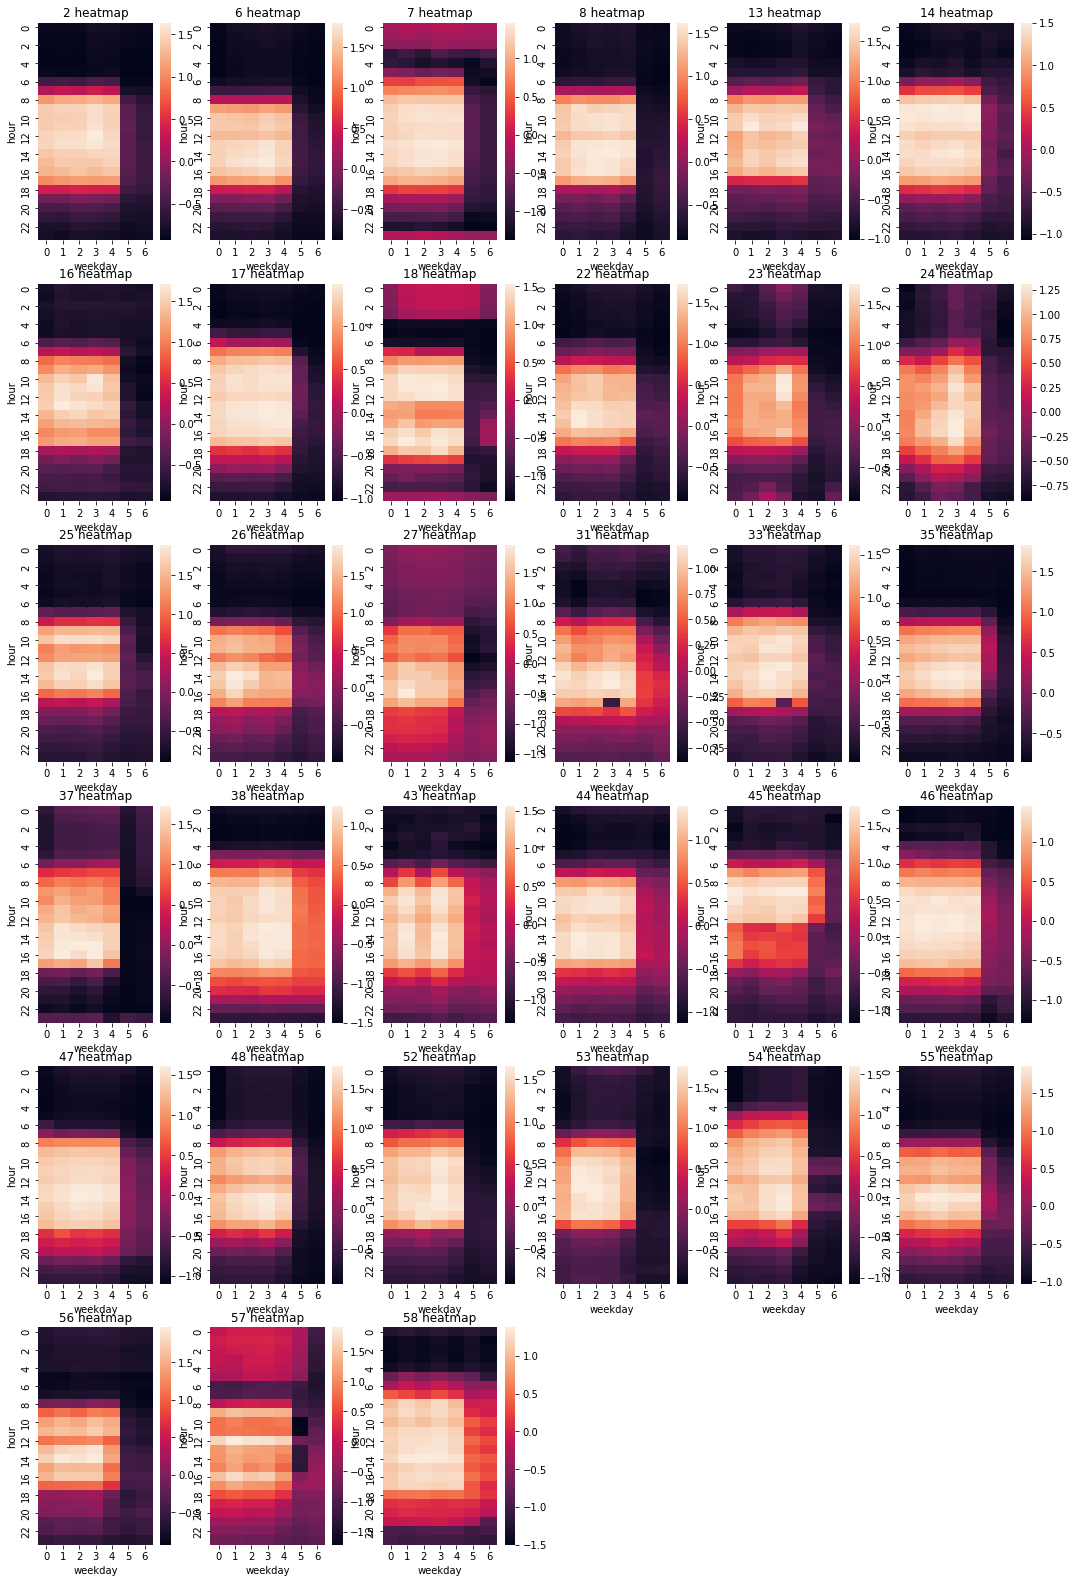

In [53]:
fig = plt.figure(figsize=(18, np.ceil(len(km_0)/5)*4))
for i, n in enumerate(km_0):
    plt.subplot(np.ceil(len(km_0)/6), 6, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['전력사용량(kWh)'].mean().unstack().T)

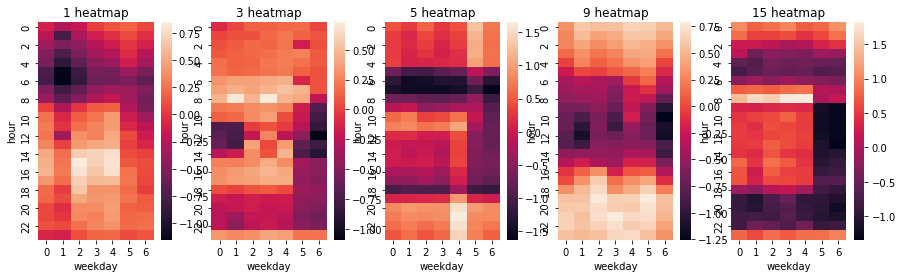

In [54]:
fig = plt.figure(figsize=(15, np.ceil(len(km_1)/5)*4))
for i, n in enumerate(km_1):
    plt.subplot(np.ceil(len(km_1)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['전력사용량(kWh)'].mean().unstack().T)

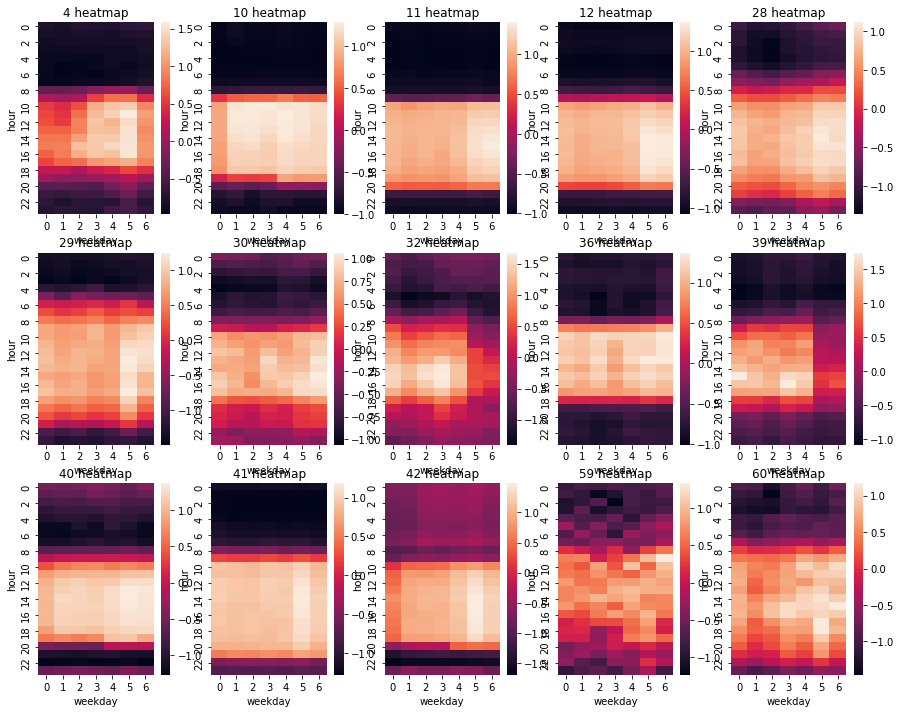

In [55]:
fig = plt.figure(figsize=(15, np.ceil(len(km_2)/5)*4))
for i, n in enumerate(km_2):
    plt.subplot(np.ceil(len(km_2)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['전력사용량(kWh)'].mean().unstack().T)

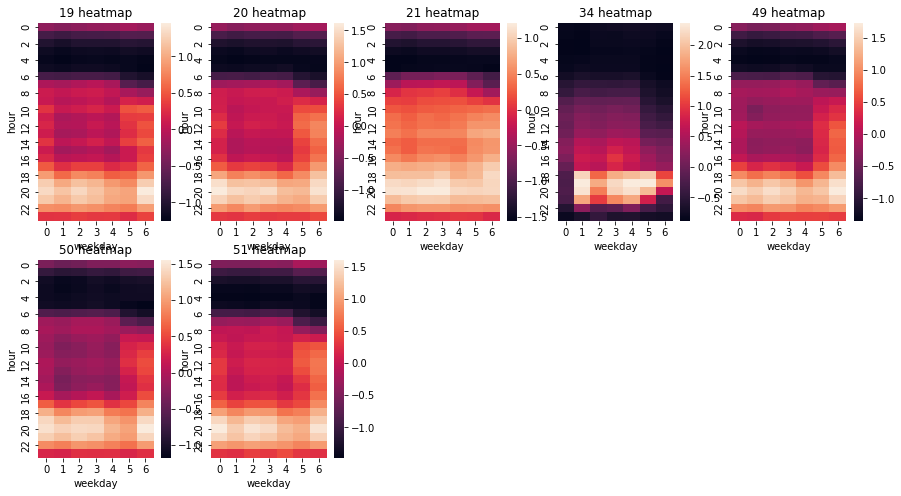

In [56]:
fig = plt.figure(figsize=(15, np.ceil(len(km_3)/5)*4))
for i, n in enumerate(km_3):
    plt.subplot(np.ceil(len(km_3)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['전력사용량(kWh)'].mean().unstack().T)

In [57]:
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,date,month,hour,weekday,holiday
0,1,2020-08-25 00:00:00,27.800000,1.500000,74.000000,0.0,0.000000,0.0,0.0,2020-08-25,8,0,1,0.0
1,1,2020-08-25 01:00:00,27.806027,1.366667,75.017358,0.0,0.000000,0.0,0.0,2020-08-25,8,1,1,0.0
2,1,2020-08-25 02:00:00,27.639360,1.233333,76.350691,0.0,0.000000,0.0,0.0,2020-08-25,8,2,1,0.0
3,1,2020-08-25 03:00:00,27.300000,1.100000,78.000000,0.0,0.000000,0.0,0.0,2020-08-25,8,3,1,0.0
4,1,2020-08-25 04:00:00,26.787947,1.166667,79.965285,0.0,0.000000,0.0,0.0,2020-08-25,8,4,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19:00:00,28.679729,3.566667,65.645299,0.0,0.533333,1.0,1.0,2020-08-31,8,19,0,0.0
10076,60,2020-08-31 20:00:00,28.313063,3.833333,66.645299,0.0,0.266667,1.0,1.0,2020-08-31,8,20,0,0.0
10077,60,2020-08-31 21:00:00,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,2020-08-31,8,21,0,0.0
10078,60,2020-08-31 22:00:00,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,2020-08-31,8,22,0,0.0


In [58]:
cl_df['km_cluster'] = pred
test_cl = pd.merge(test, cl_df[['num', 'km_cluster']], how='left', on='num')

In [59]:
test_cl

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,date,month,hour,weekday,holiday,km_cluster
0,1,2020-08-25 00:00:00,27.800000,1.500000,74.000000,0.0,0.000000,0.0,0.0,2020-08-25,8,0,1,0.0,1
1,1,2020-08-25 01:00:00,27.806027,1.366667,75.017358,0.0,0.000000,0.0,0.0,2020-08-25,8,1,1,0.0,1
2,1,2020-08-25 02:00:00,27.639360,1.233333,76.350691,0.0,0.000000,0.0,0.0,2020-08-25,8,2,1,0.0,1
3,1,2020-08-25 03:00:00,27.300000,1.100000,78.000000,0.0,0.000000,0.0,0.0,2020-08-25,8,3,1,0.0,1
4,1,2020-08-25 04:00:00,26.787947,1.166667,79.965285,0.0,0.000000,0.0,0.0,2020-08-25,8,4,1,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19:00:00,28.679729,3.566667,65.645299,0.0,0.533333,1.0,1.0,2020-08-31,8,19,0,0.0,2
10076,60,2020-08-31 20:00:00,28.313063,3.833333,66.645299,0.0,0.266667,1.0,1.0,2020-08-31,8,20,0,0.0,2
10077,60,2020-08-31 21:00:00,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,2020-08-31,8,21,0,0.0,2
10078,60,2020-08-31 22:00:00,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,2020-08-31,8,22,0,0.0,2


In [69]:
train_cl

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,date,month,hour,weekday,holiday,km_cluster
0,1,2020-06-01 00:00:00,-2.795969,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020-06-01,6,0,0,0.0,1
1,1,2020-06-01 01:00:00,-3.129259,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020-06-01,6,1,0,0.0,1
2,1,2020-06-01 02:00:00,-3.348135,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,6,2,0,0.0,1
3,1,2020-06-01 03:00:00,-3.795838,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01,6,3,0,0.0,1
4,1,2020-06-01 04:00:00,-3.835633,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020-06-01,6,4,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,1.840746,27.8,2.3,68.0,0.0,0.7,1.0,1.0,2020-08-24,8,19,0,0.0,2
122396,60,2020-08-24 20:00:00,1.504699,27.3,1.2,71.0,0.0,0.0,1.0,1.0,2020-08-24,8,20,0,0.0,2
122397,60,2020-08-24 21:00:00,0.526918,27.3,1.8,71.0,0.0,0.0,1.0,1.0,2020-08-24,8,21,0,0.0,2
122398,60,2020-08-24 22:00:00,-0.134708,27.1,1.8,74.0,0.0,0.0,1.0,1.0,2020-08-24,8,22,0,0.0,2


In [84]:
X_train = train_cl[['num', '기온(°C)', '풍속(m/s)', '습도(%)'	,'강수량(mm)','일조(hr)','비전기냉방설비운영','태양광보유',	'month','hour','weekday','holiday','km_cluster']]

In [105]:
input_window =996 #임의의 수
output_window = 24 #168 7일 24시간
window = 12 
num_features = 13 
num_power = 60
end_=168
lstm_units=32
dropout=0.2
EPOCH=30
BATCH_SIZE=128

In [106]:
train_x=tf.reshape(X_train.values, [num_power, 24*85, 13])
print(f'train_x.shape:{train_x.shape}')

train_x.shape:(60, 2040, 13)


In [107]:
import keras.backend as K

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
train_window_x= np.zeros(( train_x.shape[0], (train_x.shape[1]-(input_window + output_window))//window, input_window, num_features)) 
train_window_y= np.zeros(( train_x.shape[0], (train_x.shape[1]-(input_window + output_window))//window, output_window, num_features))
print(f'train_window_x.shape:{train_window_x.shape}')
print(f'train_window_y.shape:{train_window_y.shape}')


train_window_x.shape:(60, 85, 996, 13)
train_window_y.shape:(60, 85, 24, 13)


In [108]:
for example in range(train_x.shape[0]):
    
    for start in range(0, train_x.shape[1]-(input_window+output_window), window):
        end=start+input_window
        train_window_x[example, start//window, :] = train_x[example, start: end               , :]
        train_window_y[example, start//window, :] = train_x[example, end  : end+ output_window, :]

In [109]:
new_train_x=tf.reshape(train_window_x, [-1, input_window, num_features])
new_train_y=tf.reshape(train_window_y, [-1, output_window,num_features])
print(f'new_train_x.shape:{new_train_x.shape}')
print(f'new_train_y.shape:{new_train_y.shape}')

new_train_x.shape:(5100, 996, 13)
new_train_y.shape:(5100, 24, 13)


In [116]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape, GRU, RNN,Dropout


In [119]:
model=Sequential([
LSTM(64, return_sequences=True),
LSTM(32, return_sequences=False),
Dropout(0.2),
Dense(new_train_y.shape[1])
])
model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

In [120]:

history = model.fit(new_train_x, new_train_y, epochs=30, batch_size=16, validation_split=0.1, verbose=0, shuffle=False)


ValueError: ignored

In [ ]:
prediction=np.zeros((num_power, end_, num_features))
new_test_x=train_x

for i in range(end_//output_window):
    start_=i*output_window
    next_=model.predict(new_test_x[ : , -input_window:, :])
    new_test_x = tf.concat([new_test_x, next_], axis=1)
    print(new_test_x.shape)
    prediction[:, start_: start_ + output_window, :]= next_
prediction =prediction *size + mini

In [ ]:
y[1:25]